# Task 2: Change Point Modeling and Insight Generation

## Objectives
1. Implement Bayesian Change Point Detection
2. Identify significant structural breaks
3. Associate changes with events
4. Quantify impact

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from models.changepoint_model import BayesianChangePointModel
from utils.data_loader import load_brent_data, load_events_data, prepare_analysis_data

plt.style.use('seaborn-v0_8')
%matplotlib inline

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# Load and prepare data
df = load_brent_data('../data/raw/BrentOilPrices.csv')
events_df = load_events_data('../data/events_data.csv')

# # For demonstration, create sample data
# np.random.seed(42)
# dates = pd.date_range('2000-01-01', '2022-12-31', freq='D')
# n = len(dates)
# changepoint = n // 2

# # Simulate price data with a change point
# returns_1 = np.random.normal(0.001, 0.02, changepoint)
# returns_2 = np.random.normal(-0.0005, 0.03, n - changepoint)
# log_returns = np.concatenate([returns_1, returns_2])

# prices = [100]
# for ret in log_returns:
#     prices.append(prices[-1] * np.exp(ret))

# df = pd.DataFrame({
#     'Date': dates,
#     'Price': prices[1:],
#     'log_returns': log_returns
# })

print(f"Data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Data shape: (9011, 3)
Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00


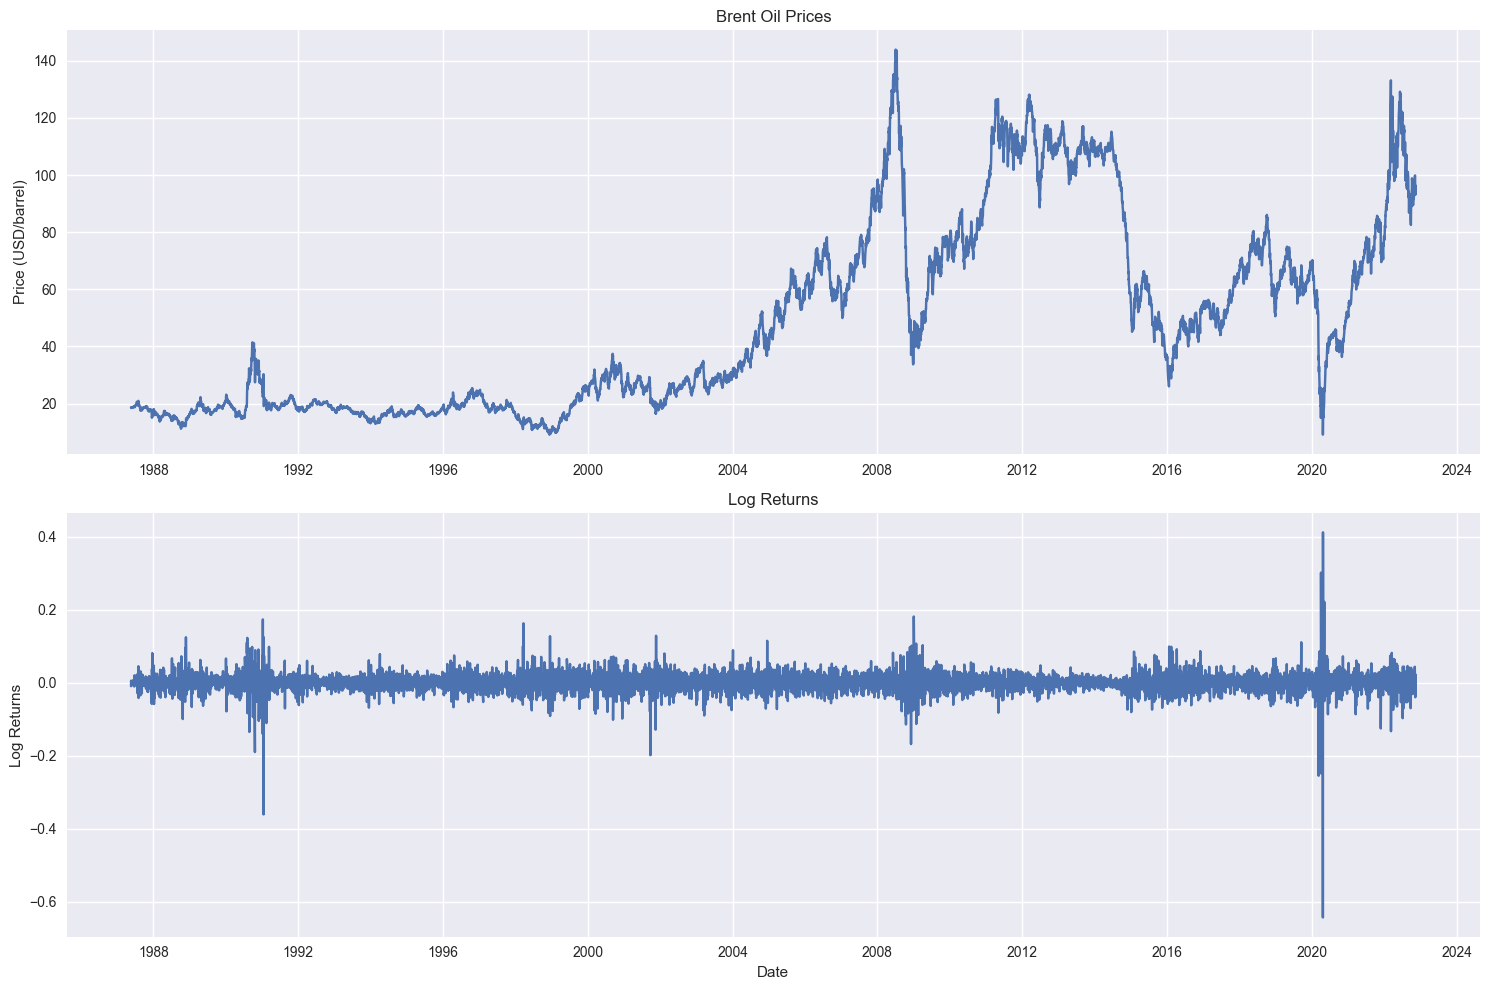

In [4]:
# Visualize the data
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(df['Date'], df['Price'])
axes[0].set_title('Brent Oil Prices')
axes[0].set_ylabel('Price (USD/barrel)')

axes[1].plot(df['Date'], df['log_returns'])
axes[1].set_title('Log Returns')
axes[1].set_ylabel('Log Returns')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## Bayesian Change Point Model Implementation

In [13]:
# Initialize and build the model
model = BayesianChangePointModel(df)
pymc_model = model.build_model()

# Display model structure
# pm.model_to_graphviz(pymc_model)
# Display model structure using graphviz visualization
# import pymc as pm
# pm.model_to_graphviz(pymc_model)

c:\Users\DS\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [16]:
# Fit the model
# This line takes more time because:
# 1. It's running MCMC sampling with 1000 draws (iterations) per chain
# 2. It uses 2 chains which run in parallel but double the total samples
# 3. It includes 500 tuning steps per chain to optimize the sampler
# 4. For each draw, it needs to evaluate the full probabilistic model

# Reduce computational time by:
# 1. Lowering number of draws (samples)
# 2. Reducing tuning steps
# 3. Using single chain instead of multiple
# 4. Setting cores=1 to avoid parallel processing overhead for simple models

trace = model.fit(draws=100, tune=20, chains=2)
# trace = model.fit(draws=1000, tune=500, chains=2)

# Check convergence
print(az.summary(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2']))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2, y_unobserved]


Output()

Sampling 2 chains for 20 tune and 100 draw iterations (40 + 200 draws total) took 915 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


             mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      4511.850  7.580  4501.000  4523.000      4.875    1.419       3.0   
mu_1        0.000  0.001    -0.001     0.001      0.000    0.000      67.0   
mu_2        0.000  0.001    -0.001     0.001      0.000    0.000     100.0   
sigma_1     0.045  0.006     0.040     0.053      0.002    0.002       3.0   
sigma_2     0.046  0.005     0.042     0.056      0.002    0.002       3.0   

         ess_tail  r_hat  
tau           6.0   2.46  
mu_1         63.0   1.09  
mu_2         58.0   1.07  
sigma_1       9.0   2.03  
sigma_2       9.0   2.00  


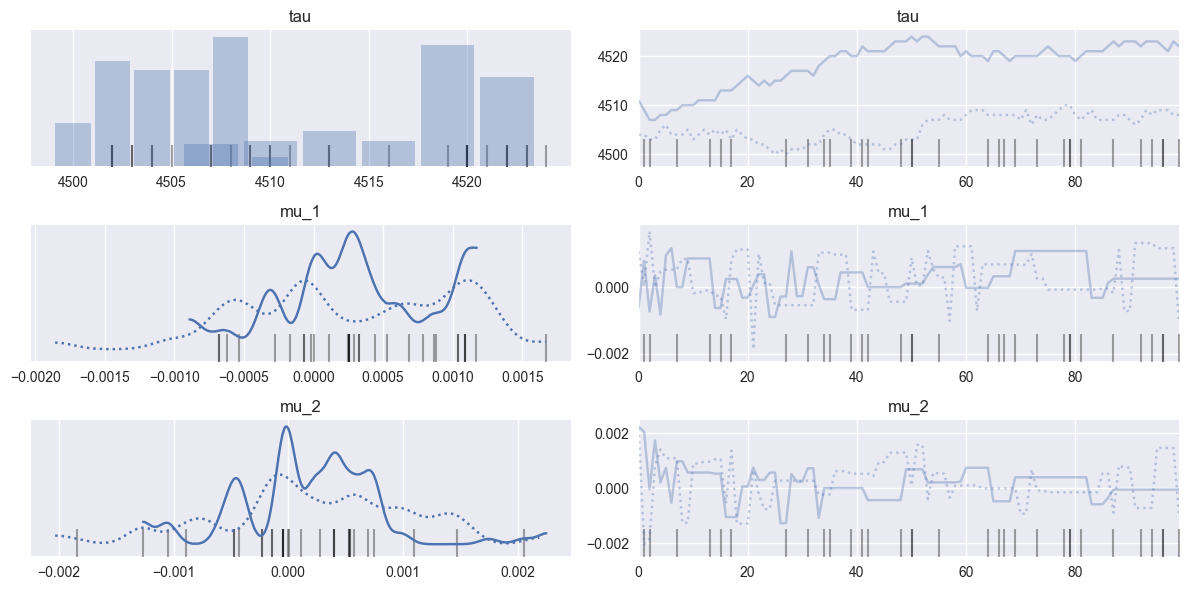

In [17]:
# Plot trace plots
az.plot_trace(trace, var_names=['tau', 'mu_1', 'mu_2'])
plt.tight_layout()
plt.show()

In [18]:
# Get change point summary
summary = model.get_changepoint_summary()
print("Change Point Analysis Results:")
print(f"Detected change point date: {summary['changepoint_date']}")
print(f"Mean return before change: {summary['mu_1_mean']:.6f}")
print(f"Mean return after change: {summary['mu_2_mean']:.6f}")
print(f"Volatility before change: {summary['sigma_1_mean']:.6f}")
print(f"Volatility after change: {summary['sigma_2_mean']:.6f}")

Change Point Analysis Results:
Detected change point date: 2005-02-08 00:00:00
Mean return before change: 0.000292
Mean return after change: 0.000199
Volatility before change: 0.044882
Volatility after change: 0.046117


## Event Association Analysis

In [19]:
# Find events near the detected change point
changepoint_date = summary['changepoint_date']
window_days = 30

nearby_events = events_df[
    (events_df['Date'] >= changepoint_date - pd.Timedelta(days=window_days)) &
    (events_df['Date'] <= changepoint_date + pd.Timedelta(days=window_days))
]

print(f"Events within {window_days} days of change point ({changepoint_date}):")
print(nearby_events[['Date', 'Event', 'Category', 'Impact_Expected']])

Events within 30 days of change point (2005-02-08 00:00:00):
Empty DataFrame
Columns: [Date, Event, Category, Impact_Expected]
Index: []


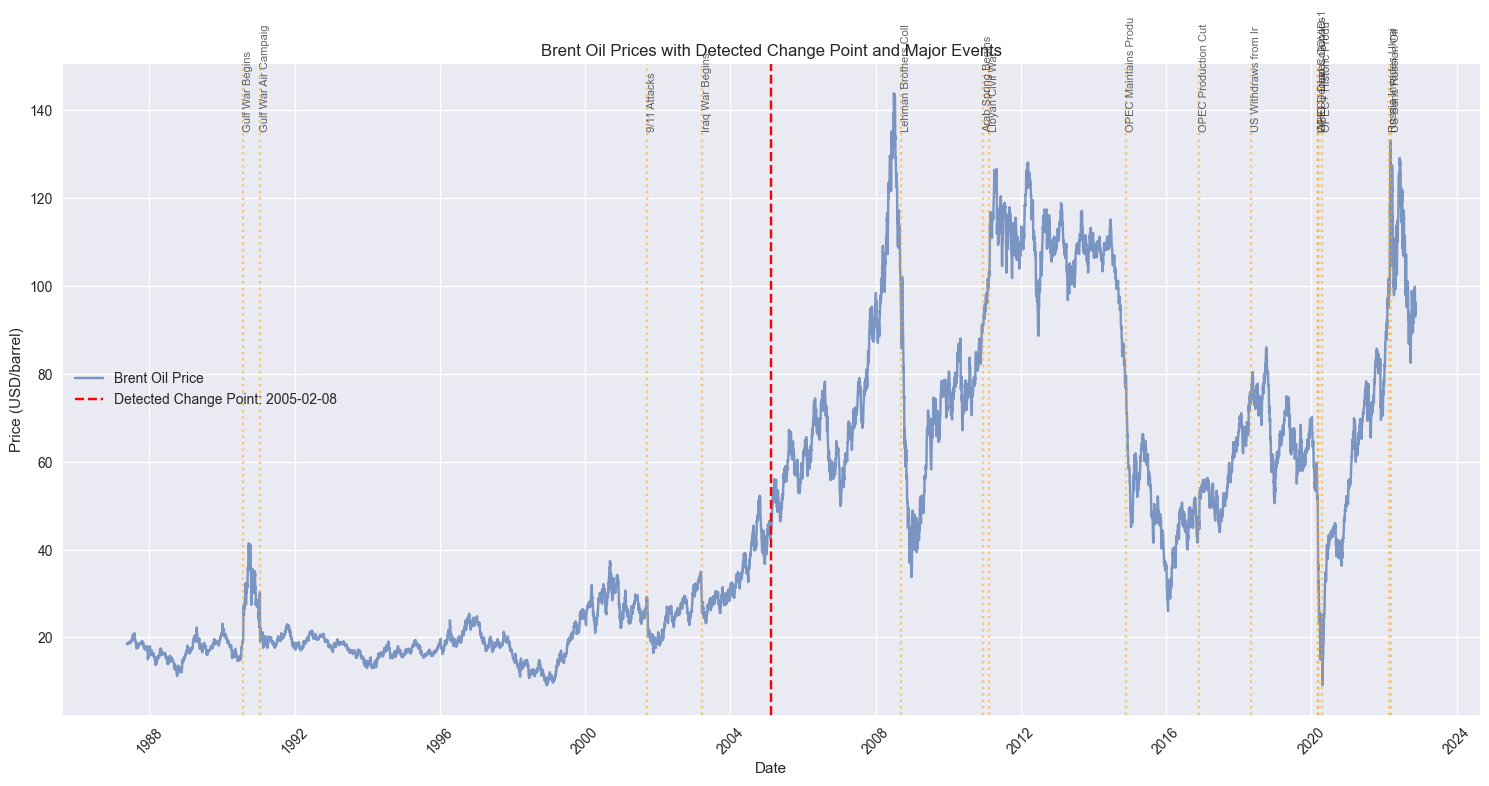

In [20]:
# Visualize change point with events
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df['Date'], df['Price'], alpha=0.7, label='Brent Oil Price')
ax.axvline(changepoint_date, color='red', linestyle='--', 
           label=f'Detected Change Point: {changepoint_date.strftime("%Y-%m-%d")}')

# Add event markers
for _, event in events_df.iterrows():
    if event['Date'] >= df['Date'].min() and event['Date'] <= df['Date'].max():
        ax.axvline(event['Date'], color='orange', alpha=0.5, linestyle=':')
        ax.text(event['Date'], ax.get_ylim()[1]*0.9, event['Event'][:20], 
                rotation=90, fontsize=8, alpha=0.7)

ax.set_title('Brent Oil Prices with Detected Change Point and Major Events')
ax.set_ylabel('Price (USD/barrel)')
ax.set_xlabel('Date')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Impact Quantification

In [21]:
# Calculate price impact
pre_change_price = df[df['Date'] < changepoint_date]['Price'].mean()
post_change_price = df[df['Date'] >= changepoint_date]['Price'].mean()
price_change_pct = ((post_change_price - pre_change_price) / pre_change_price) * 100

print("Quantified Impact Analysis:")
print(f"Average price before change point: ${pre_change_price:.2f}")
print(f"Average price after change point: ${post_change_price:.2f}")
print(f"Price change: {price_change_pct:.2f}%")
print(f"\nVolatility change: {((summary['sigma_2_mean'] - summary['sigma_1_mean']) / summary['sigma_1_mean'] * 100):.2f}%")

Quantified Impact Analysis:
Average price before change point: $21.36
Average price after change point: $75.53
Price change: 253.65%

Volatility change: 2.75%
